In [30]:
from spyglass.common import Session
from hex_maze_behavior import HexMazeBlock, HexMazeChoice
import pandas as pd

# Join HexMazeChoice with a bunch of other tables
# We need the Session table for session_id and subject_id
# We need HexMazeBlock and Trial for opto_cond and session_type
df = pd.DataFrame((HexMazeChoice() * HexMazeBlock().join_with_trial() * Session()).fetch(as_dict=True))

subject_id = "Toby"
df = df[df["subject_id"]==subject_id]
df = df[df["task_type"]=="probability change"]
#df = df[df["session_description"]=="ThetaStimLatePhase"]
#df = df[df["opto_cond"]!="no_delay"]

# Binary dependent variable
df["choose_left"] = (df["choice_direction"] == "left").astype(int)

# Open question: in Tim's paper, random effects were estimated over the levels of rat and session-within-rat.
# For Berke Lab, we only have one session (epoch) per day. BUT for Frank lab, we have multiple epochs per session.
# Do we want to estimate random effects over the level of epoch_id instead of (or in addition to??), session_id?
df["epoch_id"] = df["session_id"].astype(str) + "_epoch" + df["epoch"].astype(str)

# Keep only columns useful for regression
regression_cols = [
    "subject_id",            # random effect
    "session_id",            # nested grouping/random effect
    "epoch_id",              # nested grouping/random effect
    "session_description",   # we may want to filter based on opto sessions (Frank Lab)
    "opto_cond",             # we may want to filter based on opto condition to see effects here
    "task_type",             # we may want to filter based on `probability change` vs `barrier change`
    "block",                 # we may want to filter based on block?
    "block_trial_num",       # we may want to filter based on trial (e.g. trials >25 to allow for learning)
    "choose_left",           # binary dependent variable
    "reward_prob_diff",      # predictor
    "path_length_diff",      # predictor
]
regression_df = df[regression_cols].copy()

# Convert all non-numeric columns to 'category' dtype
for col in regression_df.columns:
    if not pd.api.types.is_numeric_dtype(regression_df[col]):
        regression_df[col] = regression_df[col].astype('str')

display(regression_df)

,subject_id,session_id,epoch_id,session_description,opto_cond,task_type,block,block_trial_num,choose_left,reward_prob_diff,path_length_diff
7074,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,2,0,-80.0,0
7075,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,3,1,-40.0,2
7076,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,4,1,80.0,0
7077,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,5,1,-40.0,-2
7078,Toby,Toby_20250310,Toby_20250310_epoch1,HexmazeNoStim,None,probability change,1,6,1,-40.0,2
...,...,...,...,...,...,...,...,...,...,...,...
22201,Toby,Toby_20250330,Toby_20250330_epoch1,HexmazeNoStim,None,probability change,3,65,1,80.0,4
22202,Toby,Toby_20250330,Toby_20250330_epoch1,HexmazeNoStim,None,probability change,3,66,0,40.0,4
22203,Toby,Toby_20250330,Toby_20250330_epoch1,HexmazeNoStim,None,probability change,3,67,1,80.0,4
22204,Toby,Toby_20250330,Toby_20250330_epoch1,HexmazeNoStim,None,probability change,3,68,0,40.0,4


### Scale data and do the regression

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
base = importr('base')
lme4 = importr('lme4')

# Extra save name so we don't keep overwriting
name = subject_id

# Create output directory if it doesn't exist so R doesn't get mad
import os
os.makedirs("regression_output", exist_ok=True)

# Scale predictors between 0-1 to compare effects in common units
# For now we scale across all sessions (what Tim did). But one could argue for within-session scaling instead
scaler = MinMaxScaler()
regression_df[['reward_prob_diff_scaled', 'path_length_diff_scaled']] = scaler.fit_transform(
    regression_df[['reward_prob_diff', 'path_length_diff']]
)

# Subset trials (maybe > 25?) to exclude periods when rats are still learning the maze and probabilities of reward
# Could do other filtering here too!
df_subset = regression_df[regression_df['block_trial_num'] < 30].copy()
    
# Convert df to R
with localconverter(pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df_subset)

# Now assign outside the converter (r_df is already an R object)
r.assign('df_r', r_df)

# Do mixed-effects regression in R
r('''
model <- glmer(
    choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | epoch_id),
    data = df_r,
    family = binomial,
    control = glmerControl(optimizer = "bobyqa")
)
''')

# Print model summary
print("model summary")
print(r('summary(model)'))

# Get fixed effects and random effects by epoch
r(f'''
# Extract fixed effects
# This is the average effect across all epochs

fixed_effects <- as.data.frame(summary(model)$coefficients)
fixed_effects$term <- rownames(fixed_effects)
write.csv(fixed_effects, "regression_output/fixed_effects_summary_{name}.csv", row.names = FALSE)

# Extract random effects by epoch
# This is the complete coefficients for each epoch (fixed effect + this epoch's deviation)

ranef_by_epoch <- as.data.frame(coef(model)$epoch_id)
ranef_by_epoch$epoch_id <- rownames(ranef_by_epoch)
write.csv(ranef_by_epoch, "regression_output/effects_by_epoch_{name}.csv", row.names = FALSE)
''')

# Read the csvs to get the results back into python
fixed_effects = pd.read_csv(f"regression_output/fixed_effects_summary_{name}.csv")
effects_by_epoch = pd.read_csv(f"regression_output/effects_by_epoch_{name}.csv")

display(fixed_effects)
display(effects_by_epoch)

model summary
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +  
    (1 + reward_prob_diff_scaled + path_length_diff_scaled |          epoch_id)
   Data: df_r
Control: glmerControl(optimizer = "bobyqa")

      AIC       BIC    logLik -2*log(L)  df.resid 
   4141.8    4196.1   -2061.9    4123.8      3087 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3171 -0.9149  0.4753  0.8977  2.9811 

Random effects:
 Groups   Name                    Variance Std.Dev. Corr       
 epoch_id (Intercept)             0.22577  0.4752              
          reward_prob_diff_scaled 0.09796  0.3130   -0.97      
          path_length_diff_scaled 1.78668  1.3367   -0.46  0.67
Number of obs: 3096, groups:  epoch_id, 36

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)
(Intercept)              0.007388   0.124460   0.

,Estimate,Std. Error,z value,Pr(>|z|),term
0,0.007388,0.124460,0.059357,0.952668,(Intercept)
1,0.066798,0.123558,0.540622,0.588768,reward_prob_diff_scaled
2,-0.054806,0.288732,-0.189815,0.849454,path_length_diff_scaled


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,epoch_id
0,-0.020329,0.196663,1.681444,Toby_20250310_epoch1
1,-0.034666,0.224735,1.987396,Toby_20250310_epoch3
2,-0.159482,0.292752,1.974299,Toby_20250310_epoch5
3,0.165174,-0.000276,0.248981,Toby_20250311_epoch1
4,-0.221853,0.096342,-1.524540,Toby_20250311_epoch3
5,0.073797,0.112565,1.193585,Toby_20250312_epoch1
6,0.123340,-0.050519,-0.862774,Toby_20250312_epoch3
7,-0.042328,0.006274,-1.388176,Toby_20250313_epoch1
8,-0.423678,0.443498,2.050136,Toby_20250313_epoch5
9,0.162169,-0.049137,-0.517600,Toby_20250314_epoch1


### Plot the regression coefficients 

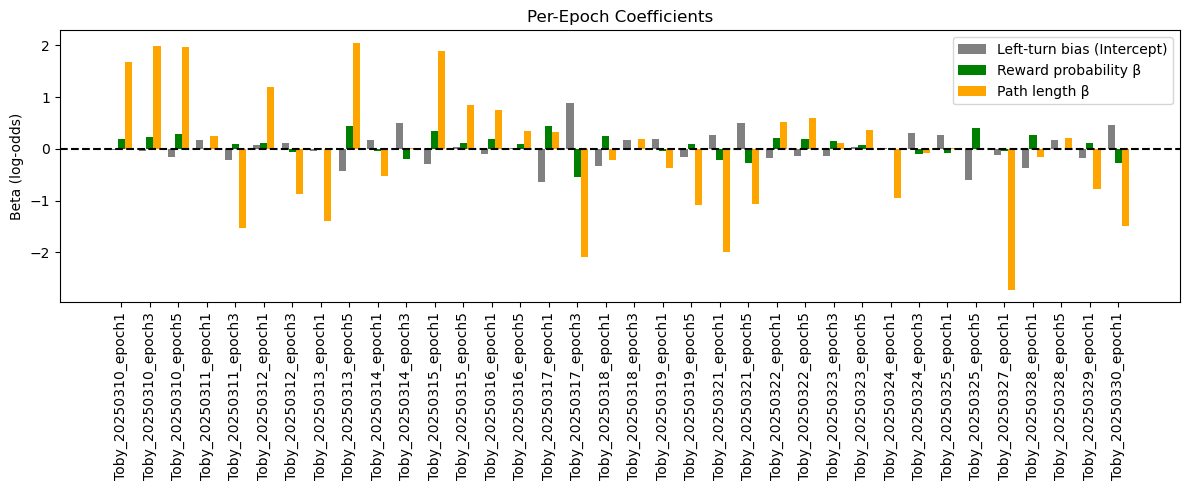

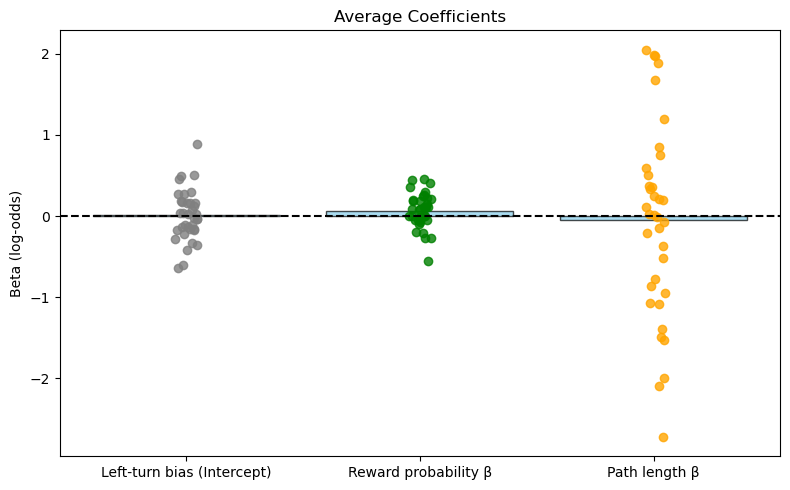

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Coefs to plot
coeffs = ["(Intercept)", "reward_prob_diff_scaled", "path_length_diff_scaled"]
labels = ["Left-turn bias (Intercept)", "Reward probability β", "Path length β"]
colors = ["grey", "green", "orange"]

# Plot bar graph of turn bias, reward beta, and path length beta for each epoch
effects_by_epoch = effects_by_epoch.sort_values("epoch_id")

x = np.arange(len(effects_by_epoch))
w = 0.25

plt.figure(figsize=(12,5))
plt.bar(x-w, effects_by_epoch[coeffs[0]], w, color=colors[0], label=labels[0])
plt.bar(x,   effects_by_epoch[coeffs[1]], w, color=colors[1], label=labels[1])
plt.bar(x+w, effects_by_epoch[coeffs[2]], w, color=colors[2], label=labels[2])
plt.axhline(0, color="black", ls="--")
plt.xticks(x, effects_by_epoch["epoch_id"], rotation=90)
plt.ylabel("Beta (log-odds)")
plt.title("Per-Epoch Coefficients")
plt.legend()
plt.tight_layout()
plt.show()

# Now plot average turn bias, reward beta, and path length beta (with dots showing values by epoch)
means = effects_by_epoch[coeffs].mean()
x = np.arange(len(coeffs))

plt.figure(figsize=(8,5))
plt.bar(x, means, color="skyblue", edgecolor="k", alpha=0.7)
for i,(coef,col) in enumerate(zip(coeffs, colors)):
    jitter = (np.random.rand(len(effects_by_epoch)) - 0.5) * 0.1
    plt.scatter(np.full(len(effects_by_epoch), x[i]) + jitter,
                effects_by_epoch[coef], color=col, alpha=0.8)
plt.xticks(x, labels)
plt.axhline(0, color="black", ls="--")
plt.ylabel("Beta (log-odds)")
plt.title("Average Coefficients")
plt.tight_layout()
plt.show()

### Plot some histograms as a sanity check

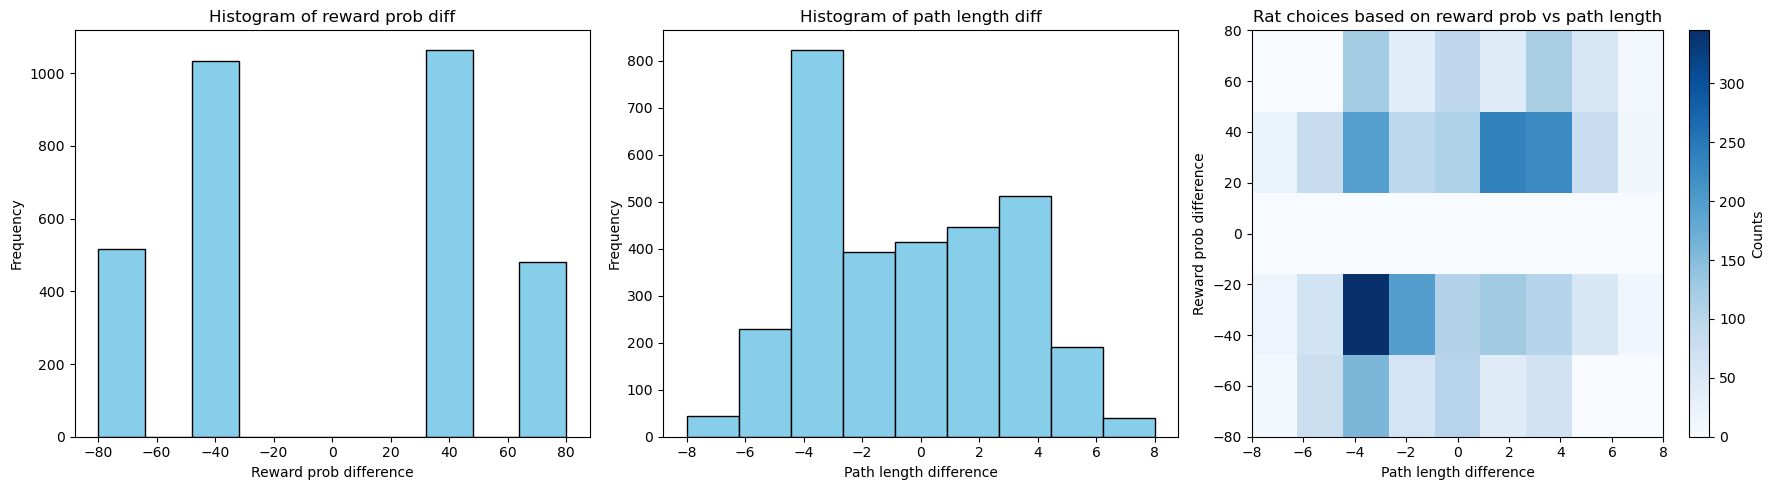

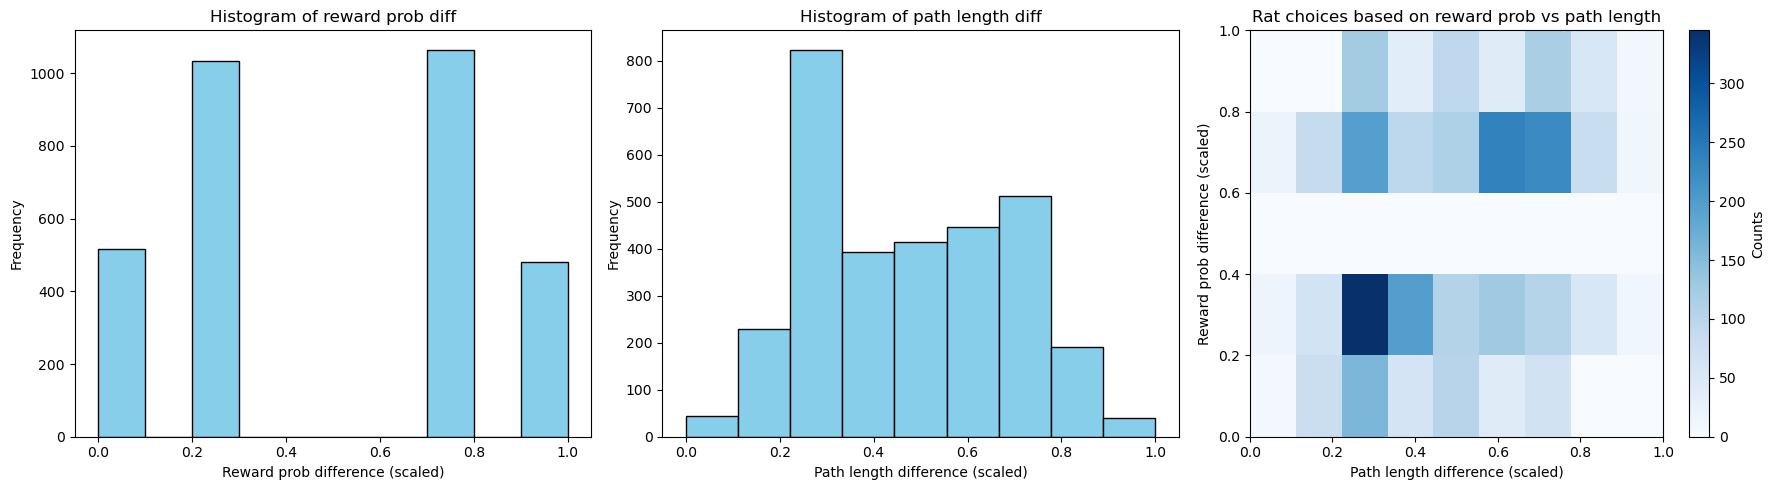

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter if we want (do the same filtering as you did for the regression)
small_df = regression_df[regression_df['block_trial_num'] <30]#[regression_df["epoch_id"]== "Toby_20250318_epoch3"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram of reward prob diff
axes[0].hist(small_df['reward_prob_diff'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Reward prob difference')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of reward prob diff')

# Histogram of path length diff
axes[1].hist(small_df['path_length_diff'], bins=9, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Path length difference')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of path length diff')

# Histogram of both
h = axes[2].hist2d(small_df['path_length_diff'], small_df['reward_prob_diff'], bins=[9, 5], cmap='Blues')
fig.colorbar(h[3], ax=axes[2], label='Counts')
axes[2].set_xlabel('Path length difference')
axes[2].set_ylabel('Reward prob difference')
axes[2].set_title('Rat choices based on reward prob vs path length')

plt.tight_layout()
plt.show()

# Again, but scaled to prove our scaling works!!
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram of reward prob diff
axes[0].hist(small_df['reward_prob_diff_scaled'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Reward prob difference (scaled)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of reward prob diff')

# Histogram of path length diff
axes[1].hist(small_df['path_length_diff_scaled'], bins=9, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Path length difference (scaled)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of path length diff')

# Histogram of both
h = axes[2].hist2d(small_df['path_length_diff_scaled'], small_df['reward_prob_diff_scaled'], bins=[9, 5], cmap='Blues')
fig.colorbar(h[3], ax=axes[2], label='Counts')
axes[2].set_xlabel('Path length difference (scaled)')
axes[2].set_ylabel('Reward prob difference (scaled)')
axes[2].set_title('Rat choices based on reward prob vs path length')

plt.tight_layout()
plt.show()

--------------------

OK it looks like Xulu designed the task such that longer paths are correlated woth higher reward probs (90/50 path is never the shortest and often the longest). Visualize it. More histograms!

,nwb_file_name,epoch,block,config_id,interval_list_name,p_a,p_b,p_c,num_trials,task_type,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
122,Toby20250310_.nwb,1,1,"10,11,15,20,31,34,38,41,44",epoch1_block1,10.0,90.0,50.0,69,probability change,Toby,"University of California, San Francisco",Loren Frank,Toby_20250310,HexmazeNoStim,2025-03-10 09:29:46,1970-01-01,Hexmaze Bandit
123,Toby20250310_.nwb,1,2,"10,11,15,20,31,34,38,41,44",epoch1_block2,90.0,10.0,50.0,69,probability change,Toby,"University of California, San Francisco",Loren Frank,Toby_20250310,HexmazeNoStim,2025-03-10 09:29:46,1970-01-01,Hexmaze Bandit
124,Toby20250310_.nwb,1,3,"10,11,15,20,31,34,38,41,44",epoch1_block3,10.0,50.0,90.0,69,probability change,Toby,"University of California, San Francisco",Loren Frank,Toby_20250310,HexmazeNoStim,2025-03-10 09:29:46,1970-01-01,Hexmaze Bandit
125,Toby20250310_.nwb,3,1,"9,10,19,21,22,29,38,41,43",epoch3_block1,90.0,10.0,50.0,69,probability change,Toby,"University of California, San Francisco",Loren Frank,Toby_20250310,HexmazeNoStim,2025-03-10 09:29:46,1970-01-01,Hexmaze Bandit
126,Toby20250310_.nwb,3,2,"9,10,19,21,22,29,38,41,43",epoch3_block2,50.0,90.0,10.0,69,probability change,Toby,"University of California, San Francisco",Loren Frank,Toby_20250310,HexmazeNoStim,2025-03-10 09:29:46,1970-01-01,Hexmaze Bandit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,Toby20250327_.nwb,7,1,"5,11,13,15,26,30,33,37,44,46",epoch7_block1,10.0,90.0,50.0,53,barrier change,Toby,"University of California, San Francisco",Loren Frank,Toby_20250327,HexmazeNoStim,2025-03-27 09:51:45,1970-01-01,Hexmaze Bandit
352,Toby20250327_.nwb,7,2,"5,11,13,15,24,30,33,37,44,46",epoch7_block2,10.0,90.0,50.0,41,barrier change,Toby,"University of California, San Francisco",Loren Frank,Toby_20250327,HexmazeNoStim,2025-03-27 09:51:45,1970-01-01,Hexmaze Bandit
353,Toby20250327_.nwb,7,3,"5,11,13,24,30,31,33,37,44,46",epoch7_block3,10.0,90.0,50.0,48,barrier change,Toby,"University of California, San Francisco",Loren Frank,Toby_20250327,HexmazeNoStim,2025-03-27 09:51:45,1970-01-01,Hexmaze Bandit
354,Toby20250327_.nwb,7,4,"5,11,13,15,24,31,33,37,44,46",epoch7_block4,10.0,90.0,50.0,29,barrier change,Toby,"University of California, San Francisco",Loren Frank,Toby_20250327,HexmazeNoStim,2025-03-27 09:51:45,1970-01-01,Hexmaze Bandit


,pair,path_length,prob
0,AB,19,50.0
1,AC,21,30.0
2,BC,21,70.0
3,AB,19,50.0
4,AC,21,70.0
...,...,...,...
697,AC,19,30.0
698,BC,17,70.0
699,AB,15,50.0
700,AC,17,30.0


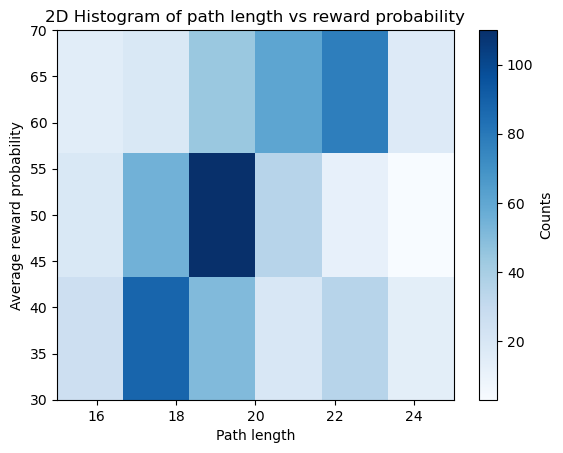

[19 21 17 23 15 25]


In [ ]:
from hexmaze import get_reward_path_lengths

subject_id = "Toby"

# Get all blocks for this rat
bias_df = pd.DataFrame((HexMazeBlock() * Session()).fetch(as_dict=True))
bias_df = bias_df[bias_df["subject_id"]==subject_id]
display(bias_df)

# Create a list to store all combinations
combinations = []

for i, row in bias_df.iterrows():
    maze = row["config_id"]
    len_ab, len_ac, len_bc = get_reward_path_lengths(maze)
    pa, pb, pc = row["p_a"], row["p_b"], row["p_c"]
    prob_ab, prob_ac, prob_bc = (pa+pb)/2, (pa+pc)/2, (pb+pc)/2
    
    combinations.append({'pair': 'AB', 'path_length': len_ab, 'prob': prob_ab})
    combinations.append({'pair': 'AC', 'path_length': len_ac, 'prob': prob_ac})
    combinations.append({'pair': 'BC', 'path_length': len_bc, 'prob': prob_bc})

# Convert to DataFrame
comb_df = pd.DataFrame(combinations)
display(comb_df)

plt.hist2d(
    comb_df['path_length'], 
    comb_df['prob'], 
    bins =[6,3],
    cmap='Blues'
)
plt.colorbar(label='Counts')
plt.xlabel('Path length')
plt.ylabel('Average reward probability')
plt.title('2D Histogram of path length vs reward probability')
plt.show()

print(comb_df['path_length'].unique())

,start,choice_pair,path_diff,prob_diff
0,A,B-C,-2,40.0
1,A,C-B,2,-40.0
2,B,A-C,-2,-40.0
3,B,C-A,2,40.0
4,C,A-B,0,-80.0
...,...,...,...,...
1399,A,C-B,2,-40.0
1400,B,A-C,-6,-40.0
1401,B,C-A,6,40.0
1402,C,A-B,-4,-80.0


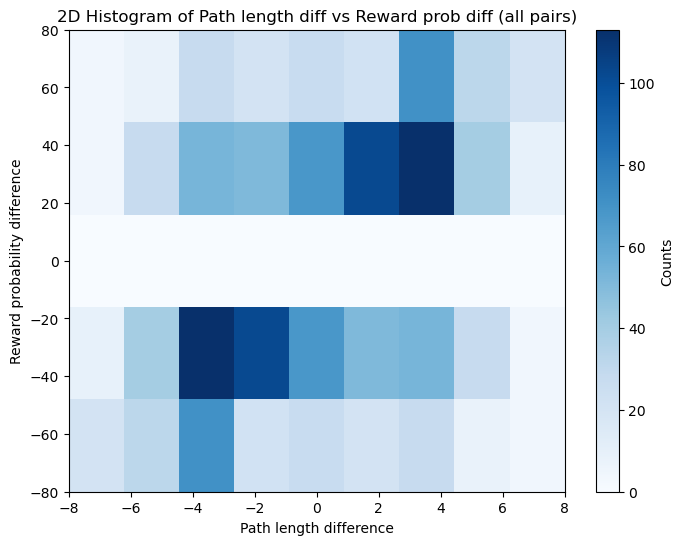

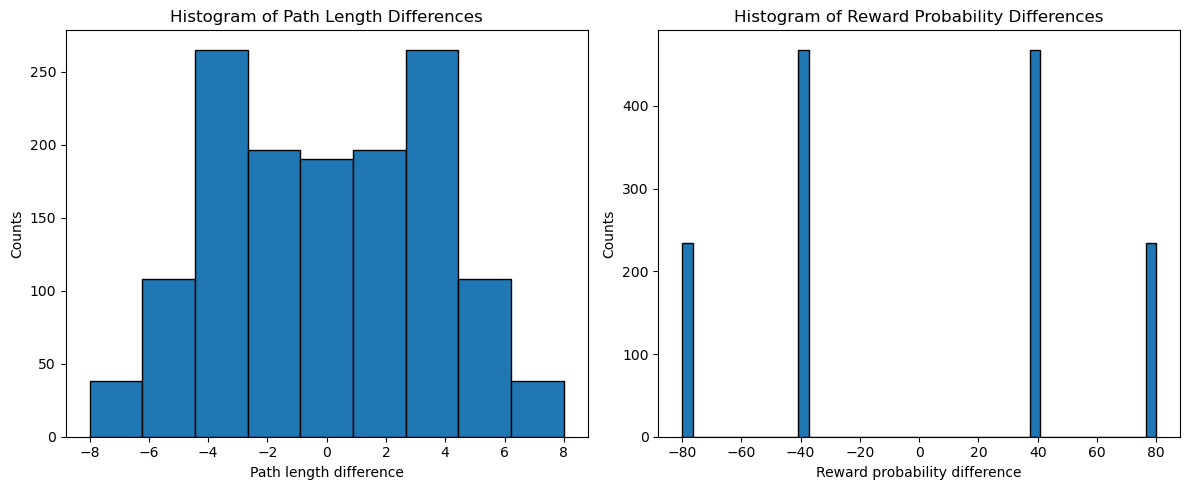

In [156]:
import pandas as pd

# List to store all differences
diffs = []

for i, row in bias_df.iterrows():
    maze = row["config_id"]
    len_ab, len_ac, len_bc = get_reward_path_lengths(maze)
    pa, pb, pc = row["p_a"], row["p_b"], row["p_c"]
    
    # From port A: B vs C
    diffs.append({'start': 'A', 'choice_pair': 'B-C', 'path_diff': len_ab - len_ac, 'prob_diff': pb - pc})
    diffs.append({'start': 'A', 'choice_pair': 'C-B', 'path_diff': len_ac - len_ab, 'prob_diff': pc - pb})
    
    # From port B: A vs C
    diffs.append({'start': 'B', 'choice_pair': 'A-C', 'path_diff': len_ab - len_bc, 'prob_diff': pa - pc})
    diffs.append({'start': 'B', 'choice_pair': 'C-A', 'path_diff': len_bc - len_ab, 'prob_diff': pc - pa})
    
    # From port C: A vs B
    diffs.append({'start': 'C', 'choice_pair': 'A-B', 'path_diff': len_ac - len_bc, 'prob_diff': pa - pb})
    diffs.append({'start': 'C', 'choice_pair': 'B-A', 'path_diff': len_bc - len_ac, 'prob_diff': pb - pa})

# Convert to DataFrame
diff_df = pd.DataFrame(diffs)
display(diff_df)


import matplotlib.pyplot as plt

# 2D histogram
plt.figure(figsize=(8,6))
plt.hist2d(
    diff_df['path_diff'], 
    diff_df['prob_diff'], 
    bins=[9, 5],  # 9 bins for path length diff, 4 bins for reward prob diff
    cmap='Blues'
)
plt.colorbar(label='Counts')
plt.xlabel('Path length difference')
plt.ylabel('Reward probability difference')
plt.title('2D Histogram of Path length diff vs Reward prob diff (all pairs)')
plt.show()



plt.figure(figsize=(12,5))

# Histogram for path length differences
plt.subplot(1, 2, 1)
plt.hist(diff_df['path_diff'], bins=9, edgecolor='black')
plt.xlabel('Path length difference')
plt.ylabel('Counts')
plt.title('Histogram of Path Length Differences')

# Histogram for reward probability differences
plt.subplot(1, 2, 2)
plt.hist(diff_df['prob_diff'], bins=45, edgecolor='black')
plt.xlabel('Reward probability difference')
plt.ylabel('Counts')
plt.title('Histogram of Reward Probability Differences')

plt.tight_layout()
plt.show()
